# Driverless AI

This notebook is intended to help you get started with AutoML in the H2O AI Cloud using python.

* **Product Documentation:** https://docs.h2o.ai/driverless-ai/1-10-lts/docs/userguide/index.html
* **Python Documentation:** https://docs.h2o.ai/driverless-ai/pyclient/docs/html/index.html
* **Additional Tutorials:** https://github.com/h2oai/driverlessai-tutorials/tree/master/dai_python_client

## Prerequisites
This tutorial relies on the latest Steam SDK (1.8.11) which can be installed into a python environment by:

1. Click on My AI Engines from the H2O AI Cloud and then `Python client` to download the wheel file
2. Navigate to the location where the python client was downloaded and install the client using `pip install h2osteam-1.8.11-py2.py3-none-any.whl`

We require the `h2o_authn` library for securely connecting to the H2O AI Cloud platform: `pip install h2o_authn`.

We also set the following variables to connect to a specific H2O AI Cloud environment. They can be found by logging into the platform, clicking on your name, and choosing the `CLI & API Access` page. Then, copy values from the `Accessing H2O AI Cloud APIs` section.

In [1]:
CLIENT_ID = "q8s-internal-platform"
TOKEN_ENDPOINT = "https://auth.demo.h2o.ai/auth/realms/q8s-internal/protocol/openid-connect/token"
REFRESH_TOKEN = "https://cloud-internal.h2o.ai/auth/get-platform-token"

H2O_STEAM_URL = "https://steam.cloud-internal.h2o.ai/"

In [55]:
from getpass import getpass

import h2o_authn
import h2osteam
from h2osteam.clients import DriverlessClient

import pandas as pd
import numpy as np

## Securely connect to the platform
We first connect to the H2O AI Cloud using our personal access token to create a token provider object. We can then use this object to log into Steam and other APIs.

In [3]:
print(f"Visit {REFRESH_TOKEN} to get your personal access token")
tp = h2o_authn.TokenProvider(
    refresh_token=getpass("Enter your access token: "),
    client_id=CLIENT_ID,
    token_endpoint_url=TOKEN_ENDPOINT
)

Visit https://cloud-internal.h2o.ai/auth/get-platform-token to get your personal access token
Enter your access token: ········


Next, we will connect to our AI Engine manager to view all instances of Driverless AI that we have access to. If you don't have an instance of Driverless AI, or you need to learn how to start your instance, please view the Enterprise Steam tutorial. 

In [4]:
steam = h2osteam.login(
    url=H2O_STEAM_URL,
    access_token=tp()
)

## Connect to Driverless AI
We'll create a connection object called dai that we will use to interact with the platform. Throughout the client you can use the .gui() function to get a link which will take you to the user interface of that specific page.

In [5]:
for instance in steam.get_driverless_instances():
    print(instance["id"], "\t", instance["profile_name"], "\t", instance["status"], "\t", instance["name"])

74 	 default-driverless-kubernetes 	 stopped 	 mt-demo
445 	 default-driverless-kubernetes 	 stopped 	 MT-test
446 	 default-driverless-kubernetes 	 running 	 dai-quickstart


In [6]:
dai = DriverlessClient().get_instance(name="dai-quickstart").connect()

In [7]:
dai.server.gui()

'https://steam.cloud-internal.h2o.ai:443/proxy/driverless/446'

In [8]:
dai.server.version

'1.10.2'

## Documentation
You can get links to the home page and search the documentation from the python client any time you want to know more about a specific DAI functionality. 

In [9]:
dai.server.docs("autoviz")

'https://steam.cloud-internal.h2o.ai:443/proxy/driverless/446/docs/userguide/search.html?q=autoviz'

## Data
Various methods for loading, interacting with, and modifiying data wihthin Driverless AI.

### List Available Connectors
View all ways you are allowed to add data to DAI on this instace - to enable more connectors update the `config.toml` file <br/><br/>
**Note:** Interactions with Data Recipes is not yet available so these connectors are not shown

In [10]:
dai.connectors.list()

['upload', 'file', 'hdfs', 's3', 'recipe_file', 'recipe_url', 'h2o_drive']

### List Existing Datasets

In [11]:
# Get a link to view all datasets in the UI
dai.datasets.gui()

print()

# List all datasets    
print(dai.datasets.list(start_index=0, count=4))

print()

# pretty print
for d in dai.datasets.list(start_index=0, count=4):
    print(type(d), d.key, d.name)


    | Type    | Key                                  | Name
----+---------+--------------------------------------+-------------------
  0 | Dataset | 5fd3a092-bb81-11ec-a1e2-a690ee1f9c81 | telco_churn_test
  1 | Dataset | 5fd36960-bb81-11ec-a1e2-a690ee1f9c81 | telco_churn_train
  2 | Dataset | 522603d6-bb81-11ec-a1e2-a690ee1f9c81 | Fancy New Name
  3 | Dataset | 462384e6-bb81-11ec-a1e2-a690ee1f9c81 | Telco_Churn

<class 'driverlessai._datasets.Dataset'> 5fd3a092-bb81-11ec-a1e2-a690ee1f9c81 telco_churn_test
<class 'driverlessai._datasets.Dataset'> 5fd36960-bb81-11ec-a1e2-a690ee1f9c81 telco_churn_train
<class 'driverlessai._datasets.Dataset'> 522603d6-bb81-11ec-a1e2-a690ee1f9c81 Fancy New Name
<class 'driverlessai._datasets.Dataset'> 462384e6-bb81-11ec-a1e2-a690ee1f9c81 Telco_Churn


### Upload and Download Data
You can upload data using any method that is enabled on your system. Here we will show:
* Add data from a public s3 link
* Download a dataset
* Upload data from your local machine
* Rename a dataset
* Upload using the JDBC connector

In [12]:
telco_churn = dai.datasets.create(data="https://h2o-internal-release.s3-us-west-2.amazonaws.com/data/Splunk/churn.csv", 
                                  data_source="s3", 
                                  name="Telco_Churn",
                                  force=True
                                 )

Complete 100.00% - [4/4] Computed stats for column Churn?


In [13]:
local_file_path = telco_churn.download("./", overwrite=True)

Downloaded 'churn.csv.1649892891.052968.csv'


In [14]:
telco_churn2 = dai.datasets.create(local_file_path, name="Telco_Churn_Duplicate")

Complete 100.00% - [4/4] Computed stats for column Churn?


In [15]:
print("Old Name:", telco_churn2.name)

telco_churn2.rename("Fancy New Name")

print("New Name:", telco_churn2.name)

Old Name: Telco_Churn_Duplicate
New Name: Fancy New Name


In [16]:
# Upload using the JDBC connector
# Note 1: You must have JDBC in the list of available connectors
# Note 2: Appropriate JARS must be on the DAI server

jdbc_config = {
    'jdbc_jar': '/data/postgresql-42.2.9.jar',
    'jdbc_driver': 'org.postgresql.Driver',
    'jdbc_url': 'jdbc:postgresql://mr-dl2:5432/h2oaidev',
    'jdbc_username': 'h2oaitester',
    'jdbc_password': 'h2oaitesterreadonly'
}

# jdbc_ds = dai.datasets.create(   
#     data='SELECT * FROM creditcardtrain',
#     data_source='jdbc',
#     data_source_config=jdbc_config,
#     name='beta_jdbc_test'
# )

### Explore the Dataset
* View the column names
* View the data shape
* View the first and last rows

In [17]:
print(telco_churn.key, "|", telco_churn.name)
print("\nColumns:", telco_churn.columns)
print('\nShape:', telco_churn.shape)

4f7ea36c-bb82-11ec-a1e2-a690ee1f9c81 | Telco_Churn

Columns: ['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Shape: (3333, 21)


In [18]:
telco_churn.head()

State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10,3,2.7,1,False.
OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.
NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,False.
OH,84,408,375-9999,yes,no,0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [19]:
telco_churn.tail()

State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False.
WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False.
RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False.
CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5,10,1.35,2,False.
TN,74,415,400-4344,no,yes,25,234.4,113,39.85,265.9,82,22.6,241.4,77,10.86,13.7,4,3.7,0,False.


### Explore the Columns
* View column summaries
* Update the datatype to be used in modeling

In [20]:
# View all column summaries
# print(telco_churn.column_summaries())

In [21]:
print(telco_churn.column_summaries(["Area Code"]))

--- Area Code ---

 408|██████████
    |████████████████████
 510|██████████

Data Type: int
Logical Types: []
Datetime Format: 
Count: 3333
Missing: 0
Mean: 437
SD: 42.4
Min: 408
Max: 510
Unique: 3
Freq: 1655



In [22]:
# Force a numeric column to only be used as a category
telco_churn.set_logical_types({'Area Code': ['categorical']})
print(telco_churn.column_summaries()["Area Code"])

--- Area Code ---

 408|██████████
    |████████████████████
 510|██████████

Data Type: int
Logical Types: ['categorical']
Datetime Format: 
Count: 3333
Missing: 0
Mean: 437
SD: 42.4
Min: 408
Max: 510
Unique: 3
Freq: 1655


### Split a Dataset
The split function returns a dictionary of two datasets so you can easily pass them to the experiments

In [23]:
telco_churn_split = telco_churn.split_to_train_test(
    train_size=0.8, 
    train_name='telco_churn_train', 
    test_name='telco_churn_test', 
    target_column= "Churn?", # Beta users with client from before March 15th use target_col
    seed=42
)

Complete


In [24]:
telco_churn_split

{'train_dataset': <class 'Dataset'> 68939f2e-bb82-11ec-a1e2-a690ee1f9c81 telco_churn_train,
 'test_dataset': <class 'Dataset'> 6893d962-bb82-11ec-a1e2-a690ee1f9c81 telco_churn_test}

In [25]:
for k, v in telco_churn_split.items():
    print(k, "\t" ,v.key, v.name)

train_dataset 	 68939f2e-bb82-11ec-a1e2-a690ee1f9c81 telco_churn_train
test_dataset 	 6893d962-bb82-11ec-a1e2-a690ee1f9c81 telco_churn_test


## Recipes
Recipes are components of the ML pipeline such as algorithms, feature transformers, and scores. You can view all availabe recipes and upload new ones to your instance of DAI.

* List all available models
* List any custom transformers
* List all scorers that can be used for binomial classification
* Upload a custom recipe and save it to be tested later

In [26]:
[m.name for m in dai.recipes.models.list()]

['Constant',
 'DecisionTree',
 'FTRL',
 'GLM',
 'ImageAuto',
 'ImbalancedLightGBM',
 'ImbalancedXGBoostGBM',
 'IsolationForestAnomaly',
 'KMeans',
 'KMeansFreq',
 'KMeansOHE',
 'LightGBM',
 'LightGBMDask',
 'RFCUML',
 'RFCUMLDask',
 'RuleFit',
 'TensorFlow',
 'TextALBERT',
 'TextBERT',
 'TextCamemBERT',
 'TextDistilBERT',
 'TextMultilingualBERT',
 'TextRoBERTa',
 'TextXLM',
 'TextXLMRoberta',
 'TextXLNET',
 'TorchGrowNet',
 'TruncSVD',
 'Unsupervised',
 'XGBoostDart',
 'XGBoostDartDask',
 'XGBoostGBM',
 'XGBoostGBMDask',
 'XGBoostRF',
 'XGBoostRFDask',
 'ZeroInflatedLightGBM',
 'ZeroInflatedXGBoost']

In [27]:
[t.name for t in dai.recipes.transformers.list() if t.is_custom ]

['SumTransformer|sum_ef3e7726_content.py']

In [28]:
[s.name for s in dai.recipes.scorers.list() if s.for_binomial]

['ACCURACY',
 'AUC',
 'AUCPR',
 'F05',
 'F1',
 'F2',
 'GINI',
 'LOGLOSS',
 'MACROAUC',
 'MACROF1',
 'MACROMCC',
 'MCC']

In [29]:
dai.recipes.create("https://github.com/h2oai/driverlessai-recipes/blob/rel-1.8.6/transformers/numeric/sum.py")

Complete 100.00%


In [30]:
[t.name for t in dai.recipes.transformers.list() if t.is_custom ]

['SumTransformer|sum_ef3e7726_content.py']

In [31]:
transformers_to_use = [t for t in dai.recipes.transformers.list() if not t.is_custom or 'Sum' in t.name]

## Modeling
**Notes:** Dictionaries allow you to easily use common settings in your experiments <br/>
**Notes:** Experiments will be `sync` by default meaning they will lock the notebook until they are complete. You can also use `async` versions of the fucntions. With the `async` functions you can use included code below to monthior and experiment as it runs, see logs in real time, and stop it when it is "good enough".

### List Existing Experiments

In [32]:
[e.name for e in dai.experiments.list()]

['Fastest Settings', 'nuwaciwo', 'credit-card-example']

### Dictionary for a Use Case
We might want to run several experiments with different dial and expert settings. All of these will likely have some things in common, namely details about this specific dataset. We will create a dictionary to use in many experiments.

In [33]:
telco_settings = {
    **telco_churn_split,
    'task': 'classification',
    'target_column': "Churn?", # Beta users with client from before March 15th use target_col
    'scorer': 'F1'
}

### Dictionary for Fast Experiments

There may be several common types of experiments you want to run, and H2O.ai will be creating common experiment settings in dictionaries for easy use. The one below turns off all extra settings such as building pipelines or checking for leakage. It also uses the fastest experiment settings.

In [34]:
fast_settings = {
    'accuracy': 1,
    'time': 1,
    'interpretability': 6,
    'make_python_scoring_pipeline': 'off',
    'make_mojo_scoring_pipeline': 'off',
    'benchmark_mojo_latency': 'off',
    'make_autoreport': False,
    'check_leakage': 'off',
    'check_distribution_shift': 'off'
}

### Search for Settings
There are many expert settings available, you can use the serach functionality to look for names or keywords for settings you may want to use.

In [35]:
dai.experiments.search_expert_settings('imbalanced')

enable_lightgbm_multiclass_balancing | default_value: auto
force_stratified_splits_for_imbalanced_threshold_binary | default_value: 0.01
imbalance_sampling_method | default_value: off
imbalance_sampling_threshold_min_rows_original | default_value: 100000
imbalance_ratio_sampling_threshold | default_value: 5
heavy_imbalance_ratio_sampling_threshold | default_value: 25
imbalance_sampling_number_of_bags | default_value: -1
imbalance_sampling_max_number_of_bags | default_value: 10
imbalance_sampling_max_number_of_bags_feature_evolution | default_value: 3
imbalance_sampling_max_multiple_data_size | default_value: 1.0
imbalance_sampling_target_minority_fraction | default_value: -1.0
imbalance_ratio_notification_threshold | default_value: 2.0


In [36]:
dai.experiments.search_expert_settings('imbalanced', show_description=True )

enable_lightgbm_multiclass_balancing | default_value: auto | LightGBM multiclass balancing
  Whether to enable automatic class weighting for imbalanced multiclass problems. Can make worse probabilities, but improve confusion-matrix based scorers for rare classes without the need to manually calibrate probabilities or fine-tune the label creation process.

force_stratified_splits_for_imbalanced_threshold_binary | default_value: 0.01 | Perform stratified sampling for binary classification if the target is more imbalanced than this.
  Ratio of minority to majority class of the target column beyond which stratified sampling is done for binary classification. Otherwise perform random sampling. Set to 0 to always do random sampling. Set to 1 to always do stratified sampling.

imbalance_sampling_method | default_value: off | Sampling method for imbalanced binary classification problems
  Sampling method for imbalanced binary classification problems. Choices are: "auto": sample both classes as

### Get Reccomended Dial Settings

In [37]:
# Get experiment preview with our settings
dai.experiments.preview(
    **telco_settings
)

ACCURACY [7/10]:
- Training data size: *2,666 rows, 20 cols*
- Feature evolution: *[Constant, LightGBM, XGBoostGBM]*, *3-fold CV**, 2 reps*
- Final pipeline: *Blend of up to 2 [Constant, LightGBM, XGBoostGBM] models, each averaged across 3-fold CV splits*

TIME [2/10]:
- Feature evolution: *8 individuals*, up to *10 iterations*
- Early stopping: After *5* iterations of no improvement

INTERPRETABILITY [8/10]:
- Feature pre-pruning strategy: Permutation Importance FS
- Monotonicity constraints: enabled
- Feature engineering search space: [CVCatNumEncode, CVTargetEncode, Frequent, Interactions, NumCatTE, NumToCatWoEMonotonic, NumToCatWoE, Original, Text, WeightOfEvidence]
- Pre-trained PyTorch NLP transformers (without fine-tuning): ['disabled']
- Pre-trained PyTorch NLP models (with fine-tuning): ['disabled']

[Constant, LightGBM, XGBoostGBM] models to train:
- Model and feature tuning: *72*
- Feature evolution: *288*
- Final pipeline: *6*

Estimated runtime: *20 minutes*
Estimated mojo

### Preview Using Our Custom Recipe
Notice that `Sum` has been added to the `Feature engineering search space`

In [38]:
# Get experiment preview with our settings
dai.experiments.preview(
    **telco_settings
    ,transformers=transformers_to_use
)

ACCURACY [7/10]:
- Training data size: *2,666 rows, 20 cols*
- Feature evolution: *[Constant, LightGBM, XGBoostGBM]*, *3-fold CV**, 2 reps*
- Final pipeline: *Blend of up to 2 [Constant, LightGBM, XGBoostGBM] models, each averaged across 3-fold CV splits*

TIME [2/10]:
- Feature evolution: *8 individuals*, up to *10 iterations*
- Early stopping: After *5* iterations of no improvement

INTERPRETABILITY [8/10]:
- Feature pre-pruning strategy: Permutation Importance FS
- Monotonicity constraints: enabled
- Feature engineering search space: [CVCatNumEncode, CVTargetEncode, Frequent, Interactions, NumCatTE, NumToCatWoEMonotonic, NumToCatWoE, Original, Sum, Text, WeightOfEvidence]
- Pre-trained PyTorch NLP transformers (without fine-tuning): ['disabled']
- Pre-trained PyTorch NLP models (with fine-tuning): ['disabled']

[Constant, LightGBM, XGBoostGBM] models to train:
- Model and feature tuning: *72*
- Feature evolution: *288*
- Final pipeline: *6*
- Transformers without MOJO support: *['Su

### Launch an Experiment
We will start by running an async experiment which will immeadiatly free our notebook to run additional commands

In [40]:
default_baseline = dai.experiments.create_async(
    **telco_settings, 
    name='Fastest Settings', **fast_settings,
    force=True
    # name='Default Baseline', accuracy=7, time=2, interpretability=8
)

Experiment launched at: https://steam.cloud-internal.h2o.ai:443/proxy/driverless/446/#/experiment?key=9f539bf4-bb82-11ec-a1e2-a690ee1f9c81


### Information on an Experiment

In [41]:
print("Name:", default_baseline.name)
print("Datasets:", default_baseline.datasets)
print("Target:", default_baseline.settings['target_column']) # beta users from before March 15th use target_col
print("Scorer:", default_baseline.metrics()['scorer'])
print("Task:", default_baseline.settings['task'])
print("Status:", default_baseline.status(verbose=2))
print("Web Page: ", end='')
default_baseline.gui()

Name: Fastest Settings
Datasets: {'train_dataset': <class 'Dataset'> 68939f2e-bb82-11ec-a1e2-a690ee1f9c81 telco_churn_train, 'validation_dataset': None, 'test_dataset': <class 'Dataset'> 6893d962-bb82-11ec-a1e2-a690ee1f9c81 telco_churn_test}
Target: Churn?
Scorer: F1
Task: classification
Status: Running 0.00% - Tuned 0/5 Parameter & feature tuning models. Tuning [GLM]
Web Page: 

'https://steam.cloud-internal.h2o.ai:443/proxy/driverless/446/#/experiment?key=9f539bf4-bb82-11ec-a1e2-a690ee1f9c81'

### Monitor and Finish the Model Early
Example of how you may want to monitor a running experiment, this will print the currently logs and accuracy metrics. You can also finish a model early if it reaches a certain accuracy metric or run time.

In [42]:
# Monitor the experiment and stop at a nice model
import time
from IPython.display import clear_output

while default_baseline.is_running():
    time.sleep(1)
    
    # grab experiment status
    status = default_baseline.status(verbose=2)
    
    # grab current metrics
    metrics = default_baseline.metrics()   
    
    # pretty print info
    clear_output(wait=True)
    print(status, " - Validation ", metrics['scorer'], ": ", sep='', end='')
    
    if metrics['val_score'] is not None:
        print(round(metrics['val_score'], 4), '+/-', round(metrics['val_score_sd'], 4))
        if metrics['val_score'] > 0.9:
            default_baseline.finish()
    else:
        print()
    
    print()
    default_baseline.log.tail(3)
    time.sleep(1)
    
print("\nTest ", default_baseline.metrics()['scorer'], ": ", 
      round(default_baseline.metrics()['test_score'], 4), sep='')

Running 95.00% - Building pipeline visualization... - Validation F1: 0.8529 +/- 0.0124

2022-04-13 23:38:11,073 C:  6% D:27.0GB  M:55.7GB  NODE:LOCAL1      724    DATA   | 65532       717  0.0  0.0 3324076 234460 ?      S    23:13   0:00 #_#_h2oai-DriverlessAI_start_h2o_recipes__start_h2o_recipes
2022-04-13 23:38:11,074 C:  6% D:27.0GB  M:55.7GB  NODE:LOCAL1      724    DATA   | 65532      1132  0.9  0.1 20510796 448132 ?     Ssl  23:13   0:13  \_ /opt/h2oai/dai/python/bin/java -ea -DdoUBench=false -Djava.io.tmpdir=/dai-data/TMPDIR -Dsys.ai.h2o.heartbeat.benchmark.enabled=false -jar /opt/h2oai/dai/python/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar -ip 127.0.0.1 -web_ip 127.0.0.1 -port 50361 -ice_root /dai-data/contrib/h2o_tmp -nthreads 8 -log_dir /dai-data/contrib/h2o_log -name DAI-H2O-RECIPES-1.10. -log_level INFO -allow_unsupported_java
2022-04-13 23:38:11,076 C:  6% D:27.0GB  M:55.7GB  NODE:LOCAL1      724    DATA   |

Test F1: 0.8045


### View the Experiment Summary

In [43]:
default_baseline.summary()

Status: Complete
Experiment: Fastest Settings (9f539bf4-bb82-11ec-a1e2-a690ee1f9c81)
  Version: 1.10.2, 2022-04-13 23:38
  Settings: 1/1/6, seed=465908712, GPUs enabled
  Train data: telco_churn_train (2666, 21)
  Validation data: N/A
  Test data: [Test] (667, 20)
  Target column: Churn? (binary, 14.479% target class)
System specs: Docker/Linux, 54 GB, 32 CPU cores, 1/1 GPU
  Max memory usage: 0.964 GB, 0 GB GPU
Recipe: AutoDL (5 iterations, 2 individuals)
  Validation scheme: stratified, 1 internal holdout
  Feature engineering: 19 features scored (18 selected)
Timing:
  Data preparation: 12.07 secs
  Shift/Leakage detection: 0.00 secs
  Model and feature tuning: 18.87 secs (6 models trained)
  Feature evolution: 1.31 secs (0 of 3 model trained)
  Final pipeline training: 27.14 secs (7 models trained)
  Python / MOJO scorer building: 0.00 secs / 5.67 secs
Validation score: F1 = 0.2529489 (constant preds of -1.776)
Validation score: F1 = 0.5109489 +/- 0.02091444 (baseline)
Validation s

### Interact with Model Artifacts
* See which are available
* Create the AutoReport
* Download the AutoReport
* Open the AutoReport

In [44]:
print("Available artifacts:", default_baseline.artifacts.list())

Available artifacts: ['logs', 'summary', 'test_predictions', 'train_predictions']


In [45]:
default_baseline.artifacts.create('autoreport')

Generating autodoc...


In [46]:
artifacts = default_baseline.artifacts.download(['autoreport'], "./", overwrite=True)

Downloaded 'report.docx'


In [47]:
# OSX
!open -a "Microsoft Word" {artifacts["autoreport"]}

# Windows - not tested
# !start {artifacts["autoreport"]}

### View Final Model Performance

In [48]:
default_baseline.metrics()

{'scorer': 'F1',
 'val_score': 0.8528610354223434,
 'val_score_sd': 0.012403134106512973,
 'val_roc_auc': 0.9241853013362421,
 'val_pr_auc': 0.8780771380289655,
 'test_score': 0.8044692737430168,
 'test_score_sd': 0.0313108250695895,
 'test_roc_auc': 0.9036896364622897,
 'test_pr_auc': 0.8325879996988325}

In [49]:
print("Validation", default_baseline.metrics()["scorer"], ":\t",round(default_baseline.metrics()['val_score'], 3))
print("Test", default_baseline.metrics()["scorer"], ":\t",round(default_baseline.metrics()['test_score'], 3))

Validation F1 :	 0.853
Test F1 :	 0.804


### Download the Test Set Predictions

In [50]:
# Download predictions from test dataset
artifacts = default_baseline.artifacts.download(['test_predictions'], "./", overwrite=True)
local_predictions = pd.read_csv(artifacts['test_predictions'])

local_predictions.head()

Downloaded 'test_preds.csv'


,Churn?.False.,Churn?.True.,Churn?.predicted(th=0.34421)
0,0.975820,0.024180,False.
1,0.984027,0.015973,False.
2,0.969247,0.030753,False.
3,0.967341,0.032659,False.
4,0.954038,0.045962,False.


### Plot ROC curve
* Download the predictions with the Actual column
* Use sklearn to calculate ROC curve
* Plot AUC & ROC Curve by a categorical column

In [51]:
preds = default_baseline.predict(telco_churn_split['test_dataset'], 
                         include_columns=["Churn?", "Area Code"])

test_predictions = pd.read_csv(preds.download("./"))

test_predictions.head()

Complete
Downloaded '9f539bf4-bb82-11ec-a1e2-a690ee1f9c81_preds_882e0973.csv'


,Area Code,Churn?,Churn?.False.,Churn?.True.
0,415,False.,0.975820,0.024180
1,408,False.,0.984027,0.015973
2,415,False.,0.969247,0.030753
3,415,False.,0.967341,0.032659
4,408,False.,0.954038,0.045962


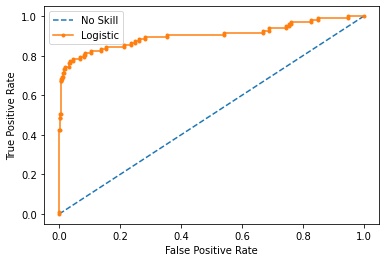

In [56]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot
%matplotlib inline

test_predictions["Actual"] = np.where(test_predictions["Churn?"] == "True.", 1, 0)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_predictions["Actual"], [0 for _ in range(len(test_predictions["Churn?"]))])
lr_fpr, lr_tpr, _ = roc_curve(test_predictions["Actual"], test_predictions["Churn?.True."])

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

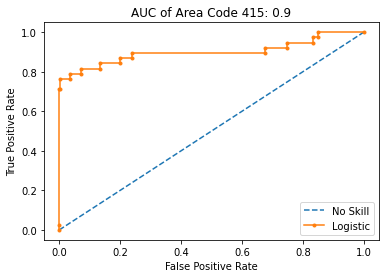

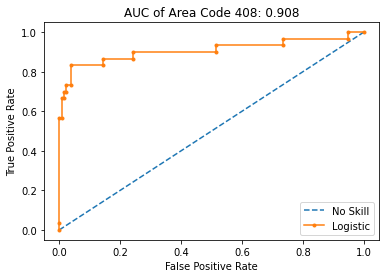

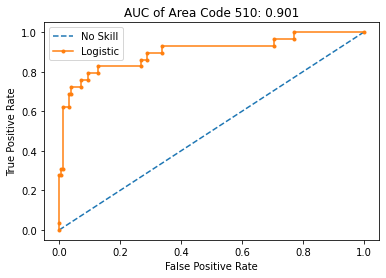

In [57]:
for ac in test_predictions["Area Code"].unique():
    grp = test_predictions[test_predictions["Area Code"] == ac]

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(grp["Actual"], [0 for _ in range(len(grp["Churn?"]))])
    lr_fpr, lr_tpr, _ = roc_curve(grp["Actual"], grp["Churn?.True."])

    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

    pyplot.title('AUC of Area Code ' + str(ac) + ': ' + str(round(auc(lr_fpr, lr_tpr), 3)))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

### Variable Importance

In [58]:
default_baseline.variable_importance()

gain,interaction,description
1,1_CustServ Calls,CustServ Calls (Original)
0.726292,4_Day Mins,Day Mins (Original)
0.663005,3_Day Charge,Day Charge (Original)
0.64795,16_CVTE:Int'l Plan.0,"Out-of-fold mean of the response grouped by: [""Int'l Plan""] using 5 folds [internal:(10, 3, 10)]"
0.623331,14_VMail Message,VMail Message (Original)
0.535766,8_Intl Calls,Intl Calls (Original)
0.520355,10_Intl Mins,Intl Mins (Original)
0.508401,9_Intl Charge,Intl Charge (Original)
0.420099,7_Eve Mins,Eve Mins (Original)
0.358189,6_Eve Charge,Eve Charge (Original)


### Retrain a Model for Production
* Retrain the final model with the full dataset
* Print the model metrics
* Create and Download the MOJO

In [59]:
dai.experiments.search_expert_settings("mojo")

make_mojo_scoring_pipeline | default_value: auto
mojo_for_predictions | default_value: auto
mojo_for_predictions_max_rows | default_value: 10000
mojo_for_predictions_batch_size | default_value: 100
mojo_acceptance_test_rtol | default_value: 0.0
mojo_acceptance_test_atol | default_value: 0.0
reduce_mojo_size | default_value: False
make_python_pipeline_visualization | default_value: auto
benchmark_mojo_latency | default_value: auto
benchmark_mojo_latency_auto_size_limit | default_value: 500
mojo_building_timeout | default_value: 1800.0
mojo_building_parallelism | default_value: -1
pytorch_nlp_pretrained_models | default_value: ['bert-base-uncased', 'distilbert-base-uncased', 'bert-base-multilingual-cased']
included_pretransformers | default_value: []
enable_rulefit | default_value: auto
enable_rapids_cuml_models | default_value: False
enable_rapids_models_dask | default_value: False
enable_lightgbm_cat_support | default_value: False
enable_lightgbm_linear_tree | default_value: False
cros

In [60]:
# Retrain on all data for productionalizing
full_model = default_baseline.retrain(final_pipeline_only=True, 
                                      train_dataset=telco_churn,
                                      test_dataset="",
                                      make_mojo_scoring_pipeline="on")

full_model = dai.experiments.get(full_model.key)

Experiment launched at: https://steam.cloud-internal.h2o.ai:443/proxy/driverless/446/#/experiment?key=414a6866-bb83-11ec-a1e2-a690ee1f9c81
Complete 100.00% - Status: Complete                            


In [61]:
full_model.metrics()

{'scorer': 'F1',
 'val_score': 0.8295454545454546,
 'val_score_sd': 0.01203503512282308,
 'val_roc_auc': 0.9185732447059678,
 'val_pr_auc': 0.8678090892706718,
 'test_score': None,
 'test_score_sd': None,
 'test_roc_auc': None,
 'test_pr_auc': None}

In [63]:
artifacts = full_model.artifacts.download("mojo_pipeline", './', overwrite=True)

Downloaded 'mojo.zip'
